https://www.kaggle.com/maxwell110/beginner-s-guide-to-audio-data-2  
https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data

In [1]:
import os
import wave
import shutil
import librosa
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd  # To play sound in the notebook
import seaborn as sns
from tqdm import tqdm_notebook
from scipy.io import wavfile

%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings("ignore", category=FutureWarning) 

### Loading data

In [2]:
data_dir = '../data/input/'
os.listdir(data_dir)

['train_curated',
 'train_curated.zip',
 'sample_submission.csv',
 'test.zip',
 'train_noisy.csv',
 'train_noisy',
 'train_curated.csv',
 'train_noisy.zip',
 'test']

In [3]:
train_curated = pd.read_csv(data_dir + 'train_curated.csv')
train_noisy = pd.read_csv(data_dir + 'train_noisy.csv')
test = pd.read_csv(data_dir + 'sample_submission.csv')

In [4]:
train_curated.sample(10)

fname                                          labels
2219  72b8e070.wav  Car_passing_by,Traffic_noise_and_roadway_noise
180   09baece9.wav                                            Purr
2034  6862be13.wav                                       Screaming
3117  a1cc7aed.wav                                    Toilet_flush
1776  5c493bd7.wav                    Bathtub_(filling_or_washing)
2925  97bb5eb0.wav                                      Skateboard
2277  76082955.wav                          Cricket,Waves_and_surf
2875  950c4874.wav                                      Skateboard
158   086716f4.wav                                  Squeak,Writing
3496  b51f230d.wav                                             Run

In [5]:
train_noisy.sample(10)

fname                                           labels
9511   7a11009c.wav                 Female_speech_and_woman_speaking
14512  ba8a2a16.wav                                    Frying_(food)
16203  d18dc368.wav                        Sink_(filling_or_washing)
13670  af8341df.wav                               Walk_and_footsteps
11964  99ea5392.wav                                          Printer
17425  e0b7b711.wav  Dishes_and_pots_and_pans,Cutlery_and_silverware
11311  91e4556a.wav                           Cutlery_and_silverware
1339   1123466b.wav                    Child_speech_and_kid_speaking
17690  e40dfd8e.wav                                   Cheering,Crowd
4511   39a4565b.wav                                             Yell

In [6]:
test.sample(10)

fname  Accelerating_and_revving_and_vroom  Accordion  \
206   0c5ba768.wav                                   0          0   
340   1451986d.wav                                   0          0   
298   1142def0.wav                                   0          0   
287   10c170b1.wav                                   0          0   
2     001ed5f1.wav                                   0          0   
777   2f8dd247.wav                                   0          0   
672   28a2ff49.wav                                   0          0   
851   3347121c.wav                                   0          0   
1067  3f16d9f3.wav                                   0          0   
603   245c01e6.wav                                   0          0   

      Acoustic_guitar  Applause  Bark  Bass_drum  Bass_guitar  \
206                 0         0     0          0            0   
340                 0         0     0          0            0   
298                 0         0     0          0            0   
287                 0         0     0          0            0   
2                   0         0     0          0            0   
777                 0         0     0          0            0   
672                 0         0     0          0            0   
851                 0         0     0          0            0   
1067                0         0     0          0            0   
603                 0         0     0          0            0   

      Bathtub_(filling_or_washing)  Bicycle_bell        ...          \
206                              0             0        ...           
340                              0             0        ...           
298                              0             0        ...           
287                              0             0        ...           
2                                0             0        ...           
777                              0             0        ...           
672                              0             0        ...           
851                              0             0        ...           
1067                             0             0        ...           
603                              0             0        ...           

      Toilet_flush  Traffic_noise_and_roadway_noise  Trickle_and_dribble  \
206              0                                0                    0   
340              0                                0                    0   
298              0                                0                    0   
287              0                                0                    0   
2                0                                0                    0   
777              0                                0                    0   
672              0                                0                    0   
851              0                                0                    0   
1067             0                                0                    0   
603              0                                0                    0   

      Walk_and_footsteps  Water_tap_and_faucet  Waves_and_surf  Whispering  \
206                    0                     0               0           0   
340                    0                     0               0           0   
298                    0                     0               0           0   
287                    0                     0               0           0   
2                      0                     0               0           0   
777                    0                     0               0           0   
672                    0                     0               0           0   
851                    0                     0               0           0   
1067                   0                     0               0           0   
603                    0                     0               0           0   

      Writing  Yell  Zipper_(clothing)  
206         0     

### Distribution of Categories

In [7]:
print("Number of train_curated examples=", train_curated.shape[0], ",  Number of classes=", len(set(train_curated.labels)))
print("Number of train_noisy examples=", train_noisy.shape[0], ",  Number of classes=", len(set(train_noisy.labels)))
print("Number of test examples=", test.shape[0], ",  Number of classes=", len(set(test.columns[1:])))

Number of train_curated examples= 4970 ,  Number of classes= 213
Number of train_noisy examples= 19815 ,  Number of classes= 1168
Number of test examples= 1120 ,  Number of classes= 80


In [8]:
def get_multilabel_flatten(data):
    flatten = []
    [flatten.extend(
        [([row["fname"], label]) for label in row["labels"].split(",")]
        ) for ind, row in data.iterrows()]
    flatten = pd.DataFrame(flatten, columns=["fname", "labels"])
    return flatten

get_multilabel_flatten(train_curated[~train_curated.labels.isin(test.columns[1:])]).head()

fname           labels
0  0041de6b.wav  Acoustic_guitar
1  0041de6b.wav            Strum
2  0073825a.wav            Crowd
3  0073825a.wav         Cheering
4  01a5de85.wav         Cheering

In [9]:
train_curated_single = train_curated[train_curated.labels.isin(test.columns[1:])]
train_curated_multi = train_curated[~train_curated.labels.isin(test.columns[1:])]
train_curated_multi_flatten = get_multilabel_flatten(train_curated_multi)

train_noisy_single = train_noisy[train_noisy.labels.isin(test.columns[1:])]
train_noisy_multi = train_noisy[~train_noisy.labels.isin(test.columns[1:])]
train_noisy_multi_flatten = get_multilabel_flatten(train_noisy_multi)

print("Number of single-labeled records in train_curated=", len(train_curated_single), ",  Number of classes=", len(set(train_curated_single.labels)))
print("Number of multi-labeled records in train_curated=", len(train_curated_multi), ",  Number of classes=", len(set(train_curated_multi_flatten.labels)), "\n")

print("Number of single-labeled records in train_noisy=", len(train_noisy_single), ",  Number of classes=", len(set(train_noisy_single.labels)))
print("Number of multi-labeled records in train_noisy=", len(train_noisy_multi), ",  Number of classes=", len(set(train_noisy_multi_flatten.labels)))

Number of single-labeled records in train_curated= 4269 ,  Number of classes= 74
Number of multi-labeled records in train_curated= 701 ,  Number of classes= 65 

Number of single-labeled records in train_noisy= 16566 ,  Number of classes= 80
Number of multi-labeled records in train_noisy= 3249 ,  Number of classes= 80


In [10]:
def plot_category_group(data):
    category_group = data.groupby('labels').count()
    category_group.columns = ["counts"]
    plot = category_group.sort_values("counts", ascending=True).plot(
        kind="barh", title="Number of Audio Samples per Category", 
        color='deeppink', figsize=(15,20)
    )
    plot.set_xlabel("Category")
    plot.set_ylabel("Number of Samples");

train_curated_single
Minimum samples per category =  3
Maximum samples per category =  75


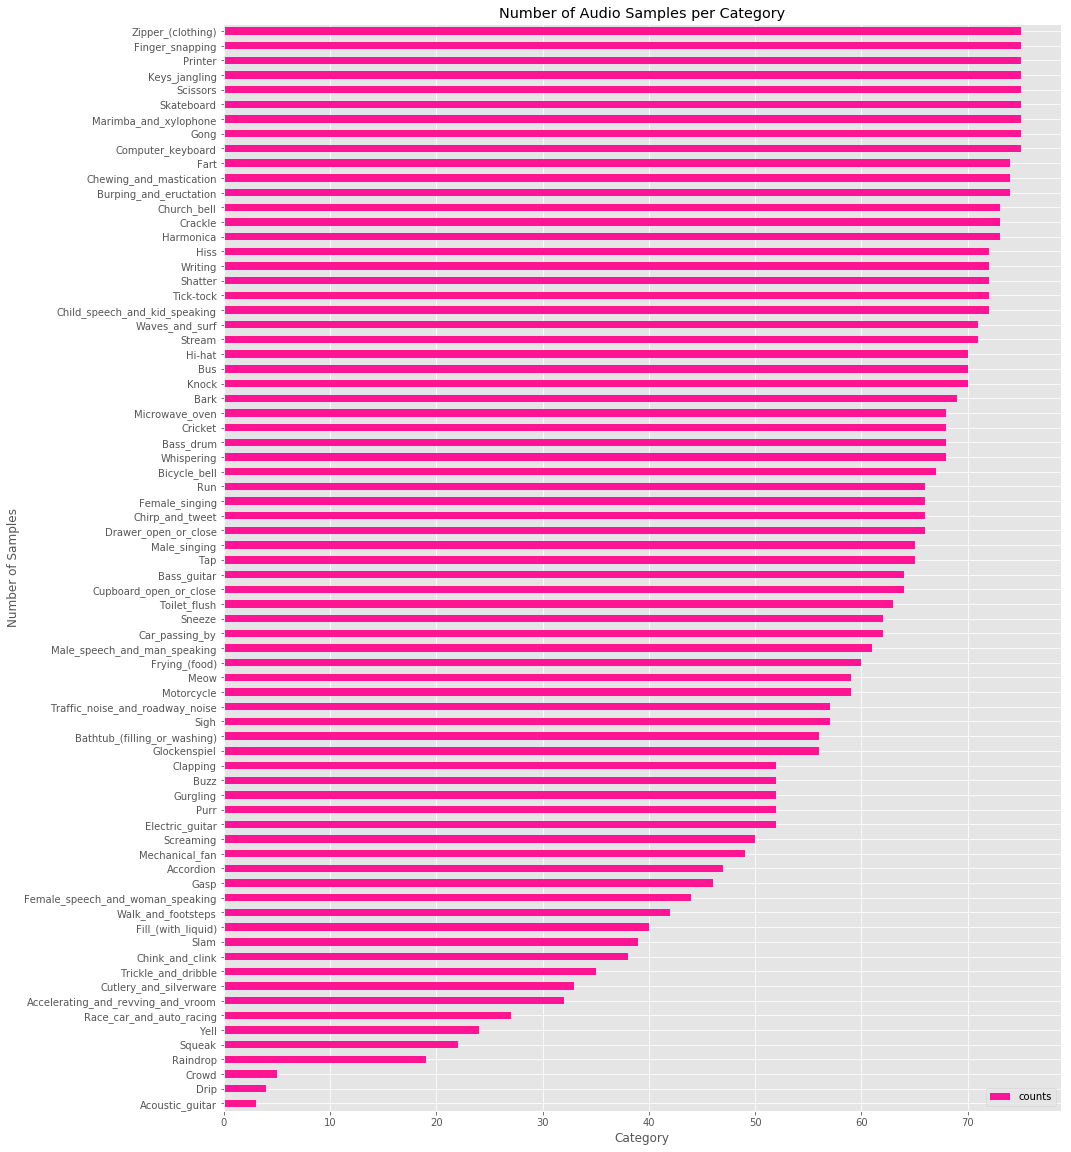

In [11]:
print("train_curated_single")
print('Minimum samples per category = ', min(train_curated_single.labels.value_counts()))
print('Maximum samples per category = ', max(train_curated_single.labels.value_counts()))
plot_category_group(train_curated_single)

train_curated_multi
Minimum samples per category =  1
Maximum samples per category =  75


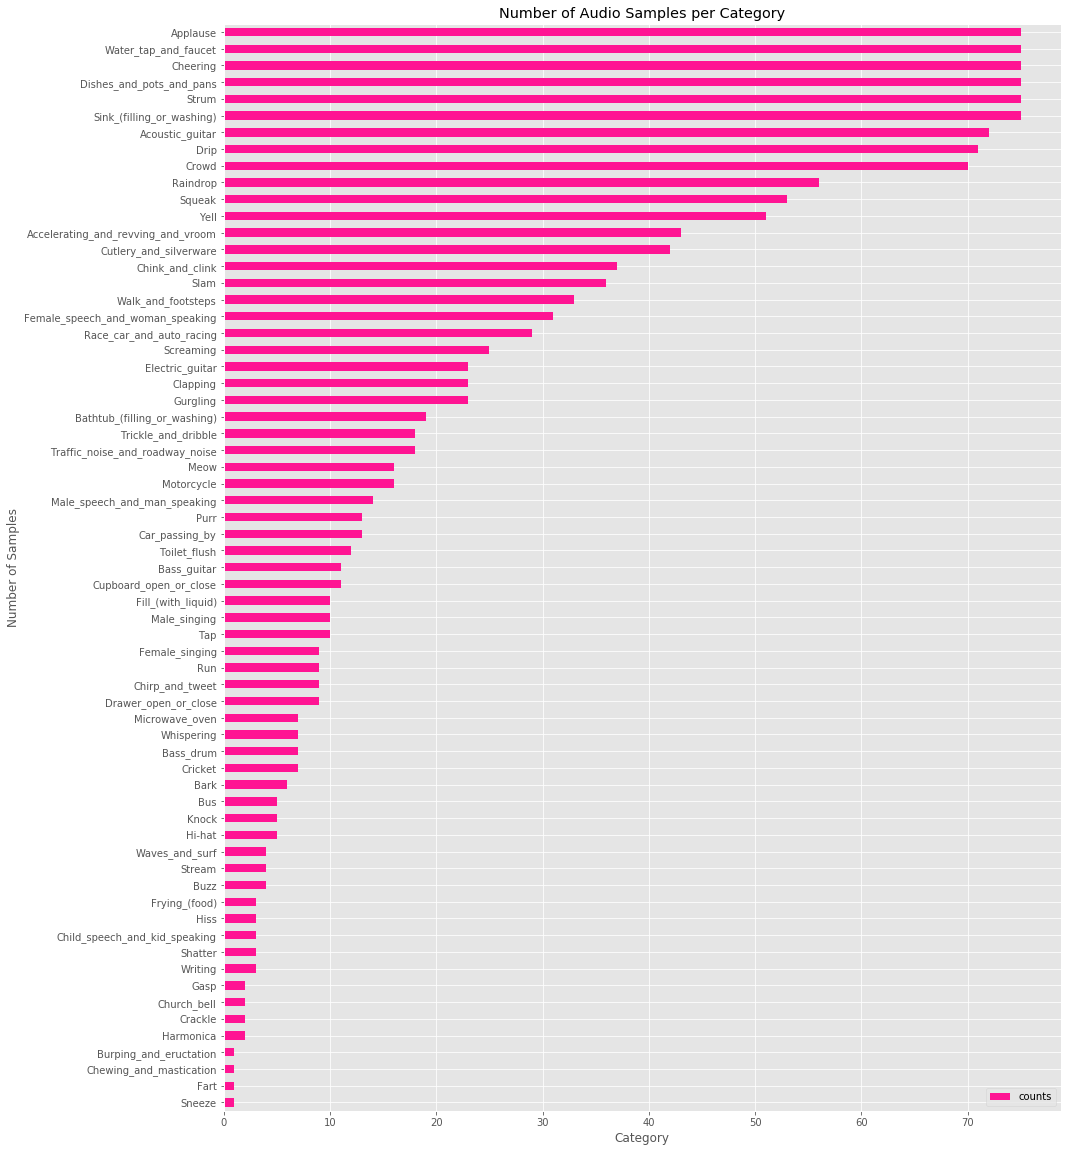

In [12]:
print("train_curated_multi")
print('Minimum samples per category = ', min(train_curated_multi_flatten.labels.value_counts()))
print('Maximum samples per category = ', max(train_curated_multi_flatten.labels.value_counts()))
plot_category_group(train_curated_multi_flatten)

train_noisy_single
Minimum samples per category =  28
Maximum samples per category =  291


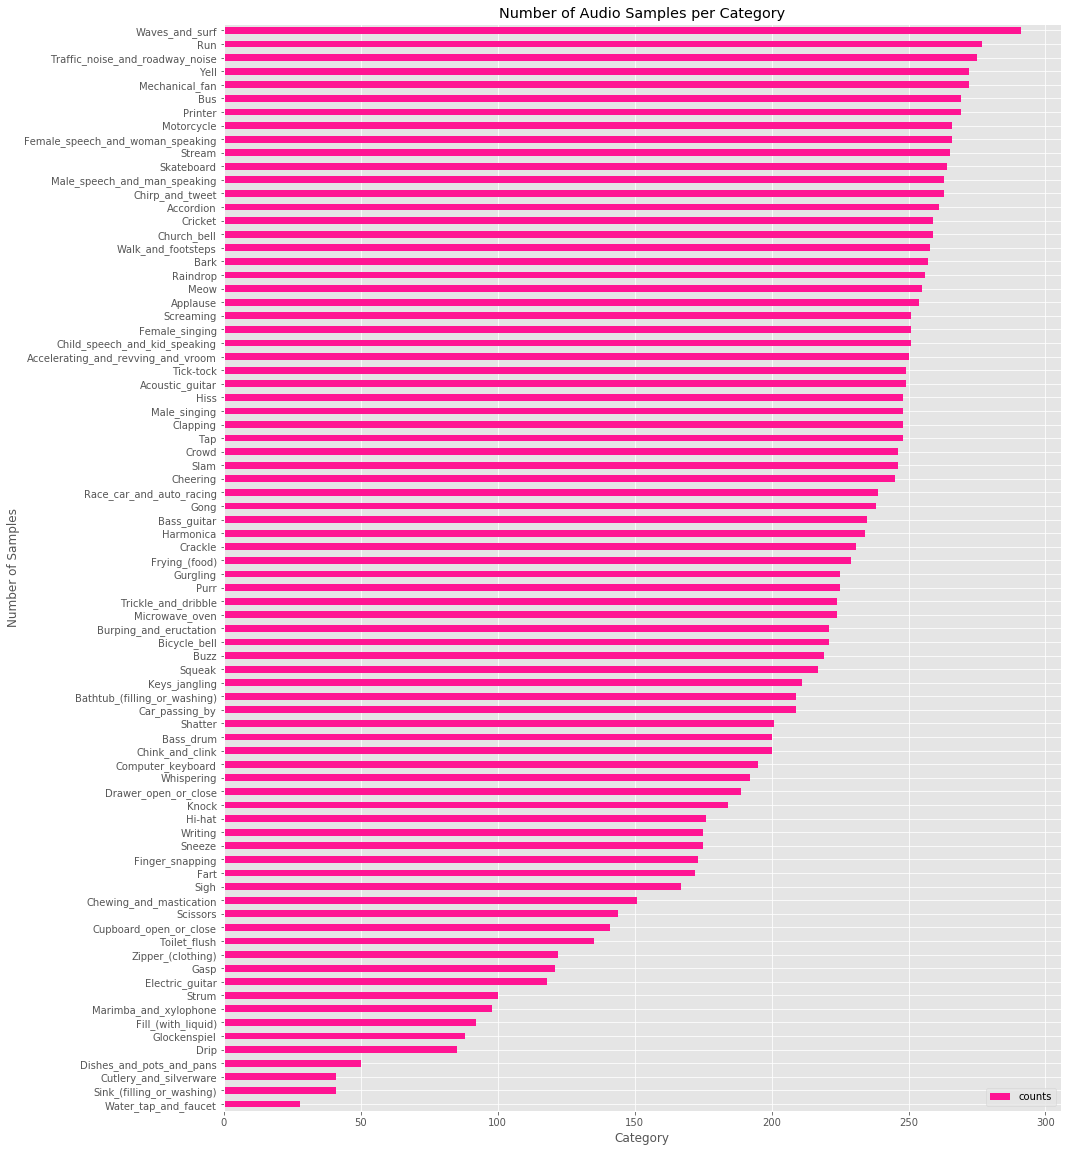

In [13]:
print("train_noisy_single")
print('Minimum samples per category = ', min(train_noisy_single.labels.value_counts()))
print('Maximum samples per category = ', max(train_noisy_single.labels.value_counts()))
plot_category_group(train_noisy_single)

train_noisy_multi
Minimum samples per category =  9
Maximum samples per category =  272


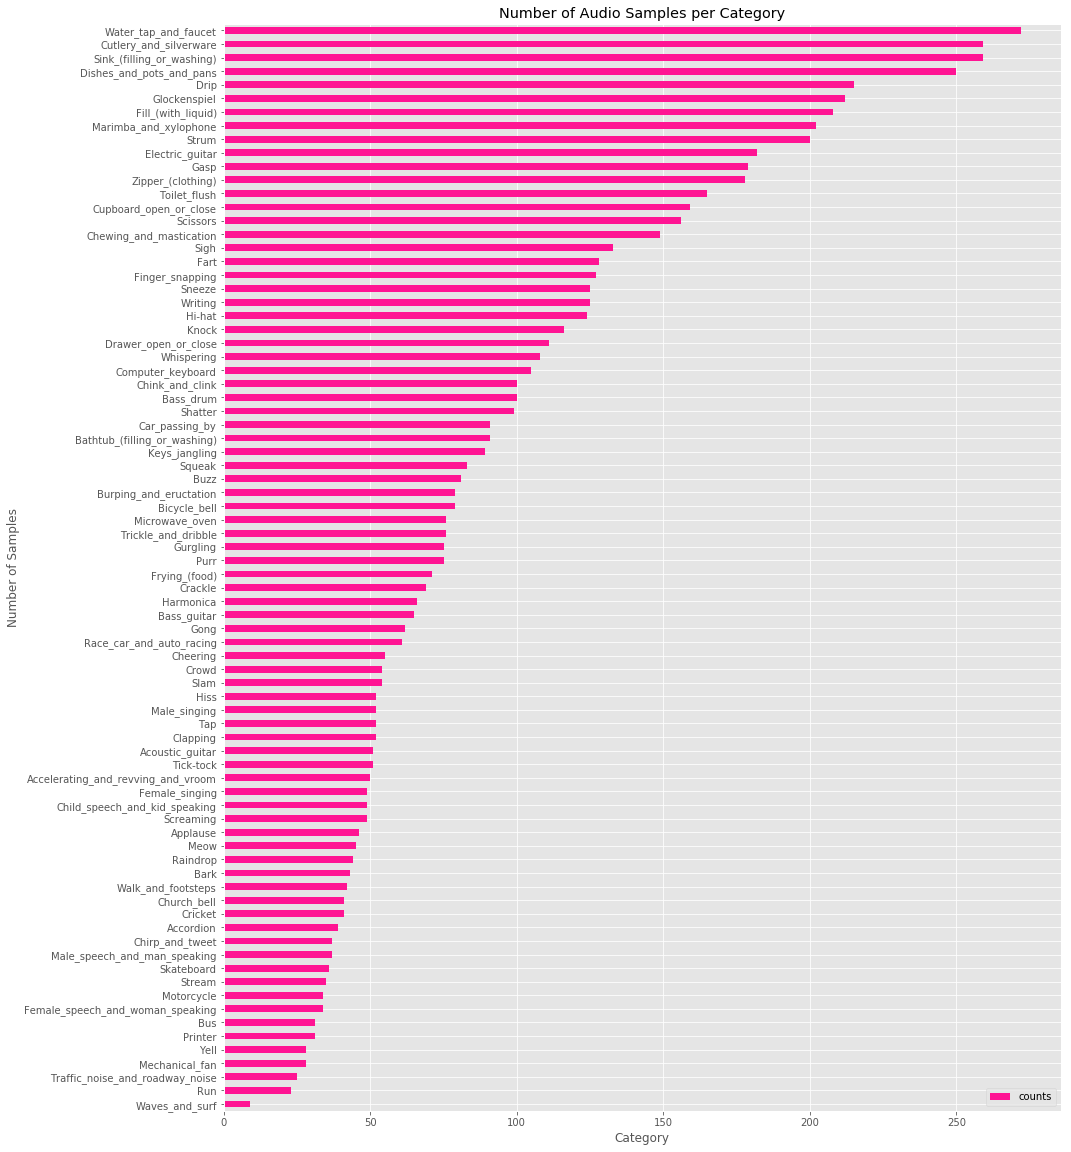

In [14]:
print("train_noisy_multi")
print('Minimum samples per category = ', min(train_noisy_multi_flatten.labels.value_counts()))
print('Maximum samples per category = ', max(train_noisy_multi_flatten.labels.value_counts()))
plot_category_group(train_noisy_multi_flatten)

In [15]:
train_curated_single.groupby("fname").size().reset_index().groupby(0).count()

fname
0       
1   4269

In [16]:
train_curated_multi_flatten.groupby("fname").size().reset_index().groupby(0).count()

fname
0       
2    627
3     69
4      4
6      1

In [17]:
train_noisy_single.groupby("fname").size().reset_index().groupby(0).count()

fname
0       
1  16566

In [18]:
train_noisy_multi_flatten.groupby("fname").size().reset_index().groupby(0).count()

fname
0       
2   2558
3    504
4    141
5     38
6      4
7      4

### Reading Audio Files

The audios are Pulse-code modulated with a bit depth of 16 and a sampling rate of 44.1 kHz

- Bit-depth = 16: The amplitude of each sample in the audio is one of 2^16 (=65536) possible values.
- Samplig rate = 44.1 kHz: Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100*3.2 = 141120 values.

In [19]:
sample_wav_file = data_dir + 'train_curated/0019ef41.wav'   # Raindrop
ipd.Audio(sample_wav_file)

In [20]:
rate, data = wavfile.read(sample_wav_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", len(data))
print("Duration = ", len(data) / rate)

Sampling (frame) rate =  44100
Total samples (frames) =  90616
Duration =  2.054784580498866


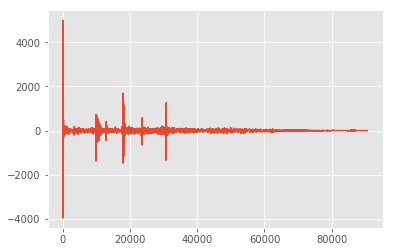

In [21]:
plt.plot(data, '-', );

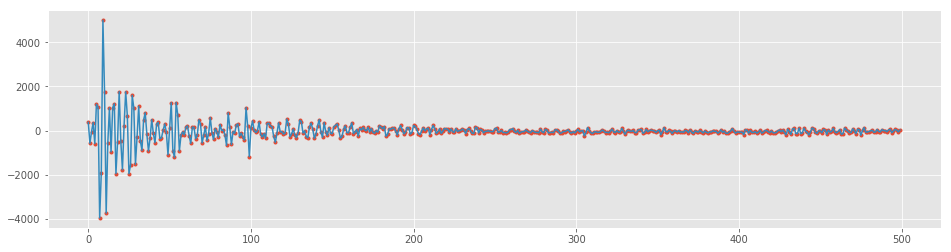

In [22]:
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

### Audio Length

In [23]:
train_curated["nframe"] = train_curated["fname"].apply(
    lambda f: wave.open(data_dir + "train_curated/" + f).getnframes()
)
train_noisy["nframe"] = train_noisy["fname"].apply(
    lambda f: wave.open(data_dir + "train_noisy/" + f).getnframes()
)
test["nframe"] = test["fname"].apply(
    lambda f: wave.open(data_dir + "test/" + f).getnframes()
)

In [24]:
train_curated.head()

fname           labels   nframe
0  0006ae4e.wav             Bark   310456
1  0019ef41.wav         Raindrop    90616
2  001ec0ad.wav  Finger_snapping    66976
3  0026c7cb.wav              Run  1125886
4  0026f116.wav  Finger_snapping    60638

In [25]:
def plot_violin(data, nhead=25):
    category_group = data[["fname", "labels"]].groupby('labels').count()
    category_group.columns = ["counts"]
    idx_sel = category_group.sort_values(ascending=True, by='counts').index[-nhead:]
 
    _, ax = plt.subplots(figsize=(20, 4))
    sns.violinplot(ax=ax, x="labels", y="nframe", data=data[(data.labels.isin(idx_sel).values)])
    plt.xticks(rotation=90)
    plt.title('Distribution of audio frames, per label', fontsize=16)

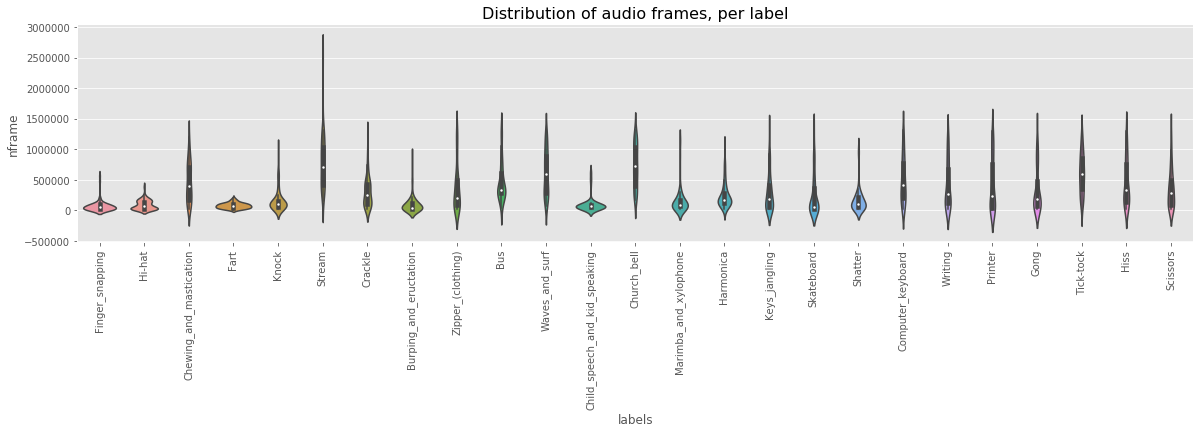

In [26]:
plot_violin(train_curated)

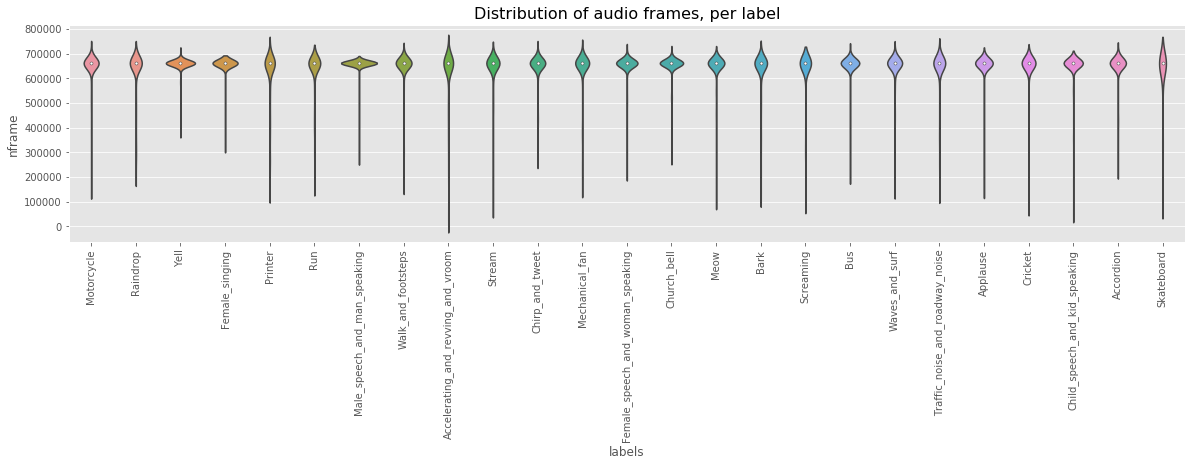

In [27]:
plot_violin(train_noisy)

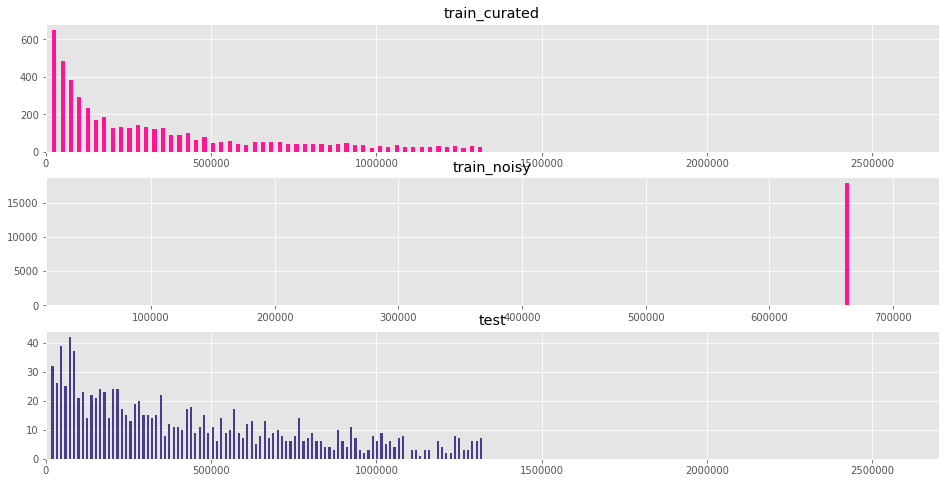

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(16,8))
train_curated.nframe.hist(bins=100, grid=True, rwidth=0.5, ax=ax[0], color='deeppink')
train_noisy.nframe.hist(bins=100, grid=True, rwidth=0.5, ax=ax[1], color='deeppink')
test.nframe.hist(bins=100, grid=True, rwidth=0.5, ax=ax[2], color='darkslateblue')
ax[0].set_xlim(0, 2700000)
ax[2].set_xlim(0, 2700000)

ax[0].set_title("train_curated")
ax[1].set_title("train_noisy")
ax[2].set_title("test");

In [29]:
train_curated.query("nframe > 2500000")

fname  labels   nframe
2316  77b925c2.wav  Stream  2538889

In [30]:
abnormal_length = 2538889

abnormal_fnames = train_curated.loc[train_curated.nframe == abnormal_length, 'fname'].values[0]
ipd.Audio(data_dir + 'train_curated/' + abnormal_fnames)

### MFCC

In [31]:
SAMPLE_RATE = 44100
sample_wav_file = data_dir + 'train_curated/0019ef41.wav'   # Raindrop
wav, _ = librosa.core.load(sample_wav_file, sr=SAMPLE_RATE)
wav = wav[:2*SAMPLE_RATE]

In [32]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
mfcc.shape

(40, 173)

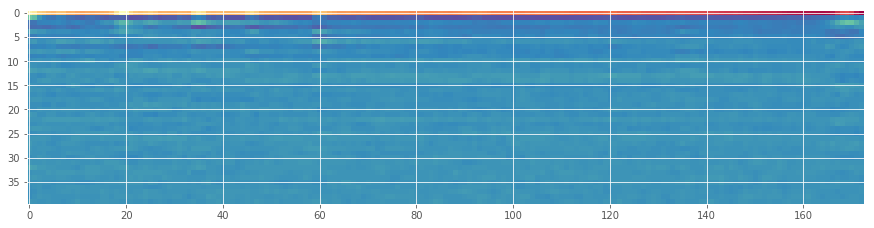

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(mfcc, cmap='Spectral', interpolation='nearest');

In [35]:
test.sort_values("nframe")

fname  Accelerating_and_revving_and_vroom  Accordion  \
294   11071bad.wav                                   0          0   
687   297219cc.wav                                   0          0   
554   21b24d69.wav                                   0          0   
600   244a60cd.wav                                   0          0   
1104  411993fd.wav                                   0          0   
215   0cfe3f96.wav                                   0          0   
122   07295dd0.wav                                   0          0   
0     000ccb97.wav                                   0          0   
875   34c53320.wav                                   0          0   
70    03fe2971.wav                                   0          0   
1097  40c1ed87.wav                                   0          0   
55    02e8059d.wav                                   0          0   
140   081d6520.wav                                   0          0   
454   1b5b6468.wav                                   0          0   
631   26a25f5d.wav                                   0          0   
238   0ddd0393.wav                                   0          0   
377   168be388.wav                                   0          0   
363   15a98fd7.wav                                   0          0   
8     00526050.wav                                   0          0   
886   352ce267.wav                                   0          0   
26    01567a3d.wav                                   0          0   
424   19c7c900.wav                                   0          0   
582   2327b6de.wav                                   0          0   
63    037b47c4.wav                                   0          0   
193   0ba7fe6b.wav                                   0          0   
1071  3f2dbd00.wav                                   0          0   
230   0d8f3f54.wav                                   0          0   
400   18551bc1.wav                                   0          0   
144   08278440.wav                                   0          0   
547   2159eea8.wav                                   0          0   
...            ...                                 ...        ...   
359   15868ee8.wav                                   0          0   
52    02d01f40.wav                                   0          0   
158   08bc3e2d.wav                                   0          0   
455   1b5daf72.wav                                   0          0   
43    022e3b2c.wav                                   0          0   
740   2d666c1d.wav                                   0          0   
1068  3f19e53c.wav                                   0          0   
155   08810dd4.wav                                   0          0   
62    03754ab4.wav                                   0          0   
360   159b8b9b.wav                                   0          0   
160   08d4acca.wav                                   0          0   
493   1de84153.wav                                   0          0   
137   08087580.wav                                   0          0   
506   1e8a965c.wav                                   0          0   
618   25c32640.wav                                   0          0   
728   2cf4955c.wav                                   0          0   
1010  3bda5fb0.wav                                   0          0   
253   0ee80cb7.wav                                   0          0   
830   322c634e.wav                                   0          0   
965   39723c0e.wav                                   0          0   
172   0997968e.wav                                   0          0   
186   0af7446d.wav                                   0          0   
576   22c9b301.wav                                   0          0   
671   289fb0b8.wav                                   0          0   
341   145a10e4.wav                                   0          0   
758   2eade3e1.wav                                   0          0   
826   320b9